# CelebA

In [1]:
import torch
from torchvision import transforms
from torchvision.datasets import CelebA

C:\Users\jvialard\anaconda3\envs\faiss\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load dataset
transform = transforms.Compose([
   transforms.Resize(64),
   transforms.CenterCrop(64),
   transforms.ToTensor(),
   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # to have inputs between [-1, 1]
])

testset = CelebA("./", split="test", target_type="attr", transform=transform, download=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Variational Auto Encoder

In [3]:
import torch
from vae.vae import VariationalAutoEncoder

In [4]:
model = VariationalAutoEncoder()
model.load_state_dict(torch.load("./checkpoints/vae_1101184303.ckpt"))
model.eval()

VariationalAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.1)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.1)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=Fa

# Visualization

## Reconstruct

In [5]:
import numpy as np
import matplotlib.pyplot as plt

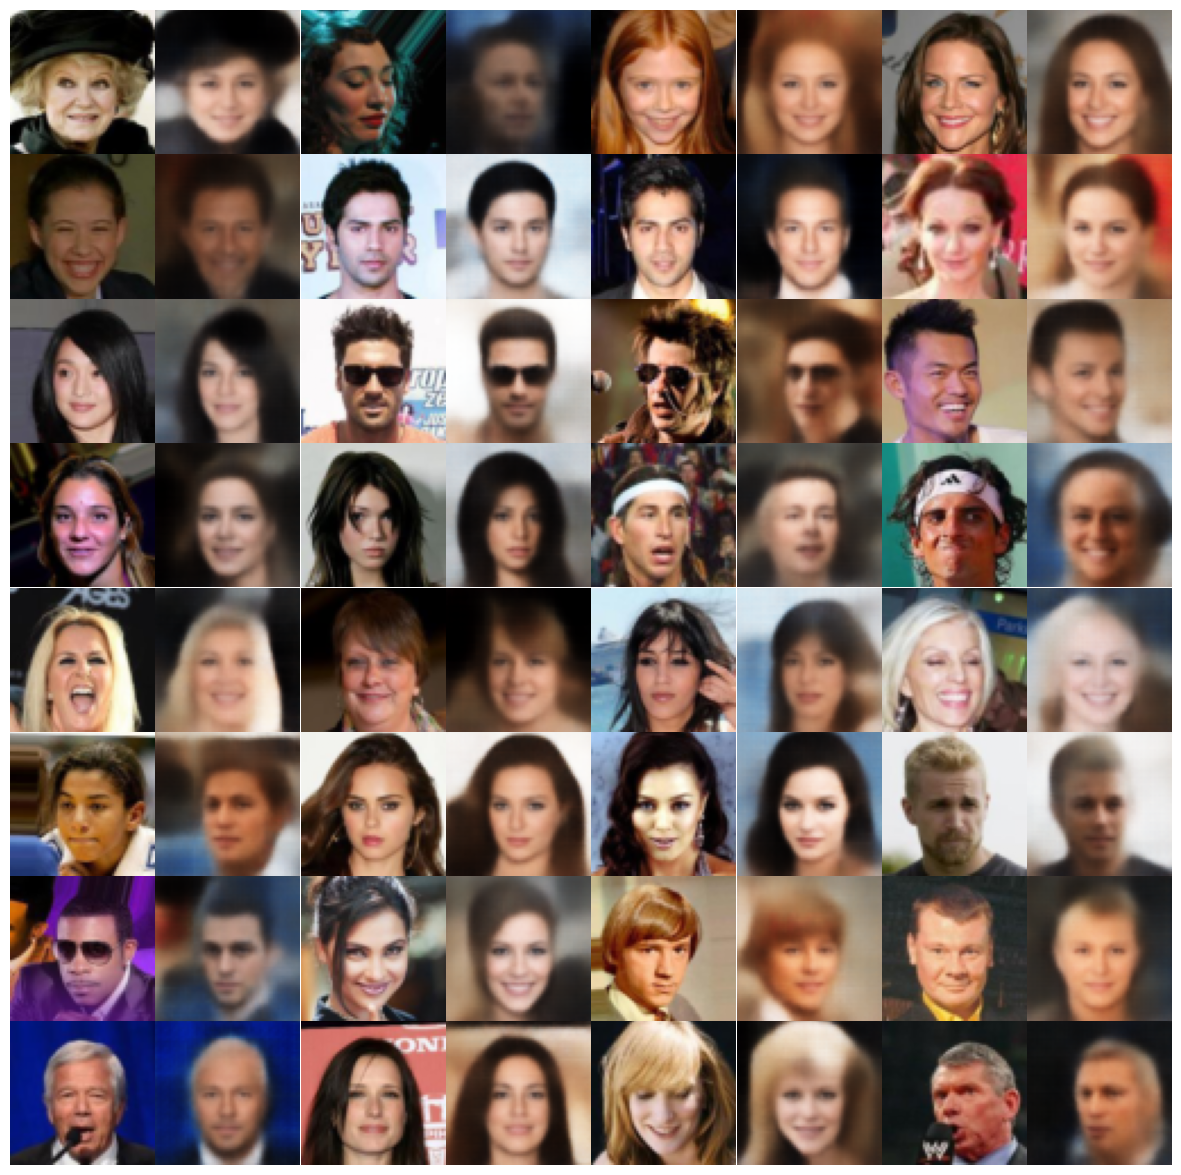

In [6]:
with torch.no_grad():
    real_img, labels = next(iter(testloader))
    recons, mu, log_var = model(real_img)
    
    real_img = real_img.detach().cpu().numpy()
    recons = recons.detach().cpu().numpy()
    
    f, axarr = plt.subplots(8, 8, figsize=(15, 15))
    for index, axarr_ in enumerate(axarr):
        for i in range(4):
            axarr_[2*i].imshow((np.moveaxis(real_img[4*index+i], 0, 2) + 1)/2)
            axarr_[2*i+1].imshow((np.moveaxis(recons[4*index+i], 0, 2) + 1)/2)       
        [e.axis('off') for e in axarr_]
    f.subplots_adjust(wspace=0, hspace=0)

## Interpolate

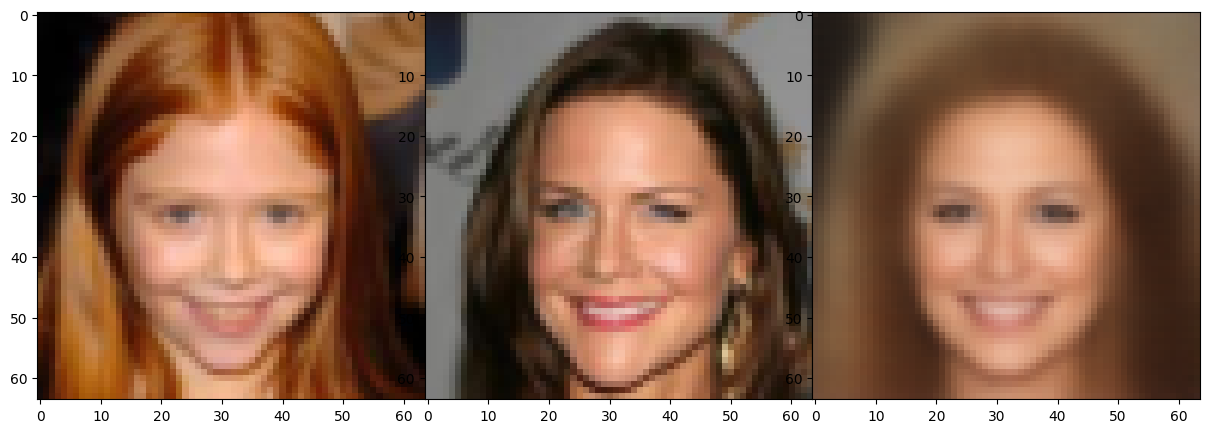

In [7]:
with torch.no_grad():
    real_img, labels = next(iter(testloader))
    h = model.encoder(real_img)
    h = torch.flatten(h, start_dim=1)
    mu = model.fc_mu(h)
    mu = ((mu[2]+mu[3])/2).unsqueeze(0)
    recons = model.decoder_input(mu)
    recons = recons.view(-1, 512, 2, 2)
    recons = model.decoder(recons) 
    
    real_img = real_img.detach().cpu().numpy()
    recons = recons.detach().cpu().numpy()
    
    f, axarr = plt.subplots(1, 3, figsize=(15, 15))
    axarr[0].imshow((np.moveaxis(real_img[2], 0, 2) + 1)/2)
    axarr[1].imshow((np.moveaxis(real_img[3], 0, 2) + 1)/2)
    axarr[2].imshow((np.moveaxis(recons[0], 0, 2) + 1)/2)
    f.subplots_adjust(wspace=0, hspace=0)

## Generate

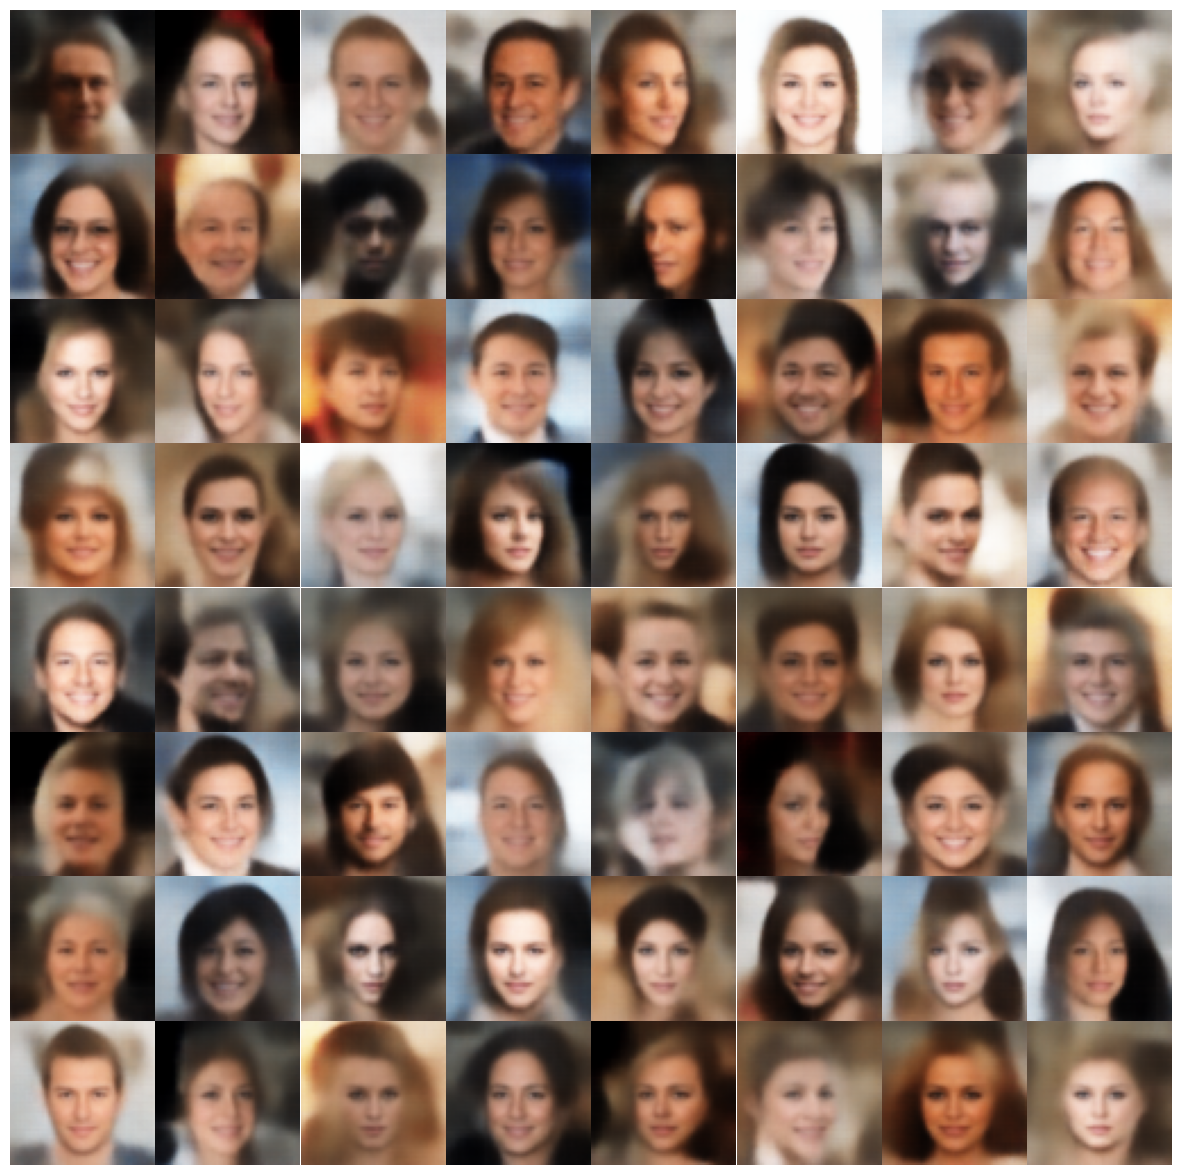

In [8]:
with torch.no_grad():
    noise = torch.normal(mean=0, std=1, size=(64, 128))
    recons = model.decoder_input(noise)
    recons = recons.view(-1, 512, 2, 2)
    recons = model.decoder(recons)    
    
    recons = recons.detach().cpu().numpy()
    
    f, axarr = plt.subplots(8, 8, figsize=(15, 15))
    for index, axarr_ in enumerate(axarr):
        for i in range(4):
            axarr_[2*i].imshow((np.moveaxis(recons[8*index+2*i], 0, 2) + 1)/2)
            axarr_[2*i+1].imshow((np.moveaxis(recons[8*index+2*i+1], 0, 2) + 1)/2)       
        [e.axis('off') for e in axarr_]
    f.subplots_adjust(wspace=0, hspace=0)

# Similarity in Encoding space

## FAISS

In [9]:
import faiss
from tqdm import tqdm

In [10]:
xb = []
real_imgs = []
with torch.no_grad():
    for real_img, labels in tqdm(testloader):
        batch_size = real_img.size(0)
        z = model.encoder(real_img).view(batch_size, -1).numpy()
        xb.append(z)
        real_imgs.append(real_img.detach().numpy())

100%|██████████| 312/312 [00:38<00:00,  8.15it/s]


In [11]:
xb = np.concatenate(xb)
real_imgs = np.concatenate(real_imgs)

In [12]:
d = xb.shape[1]
index = faiss.IndexFlatL2(d)
index.add(xb)

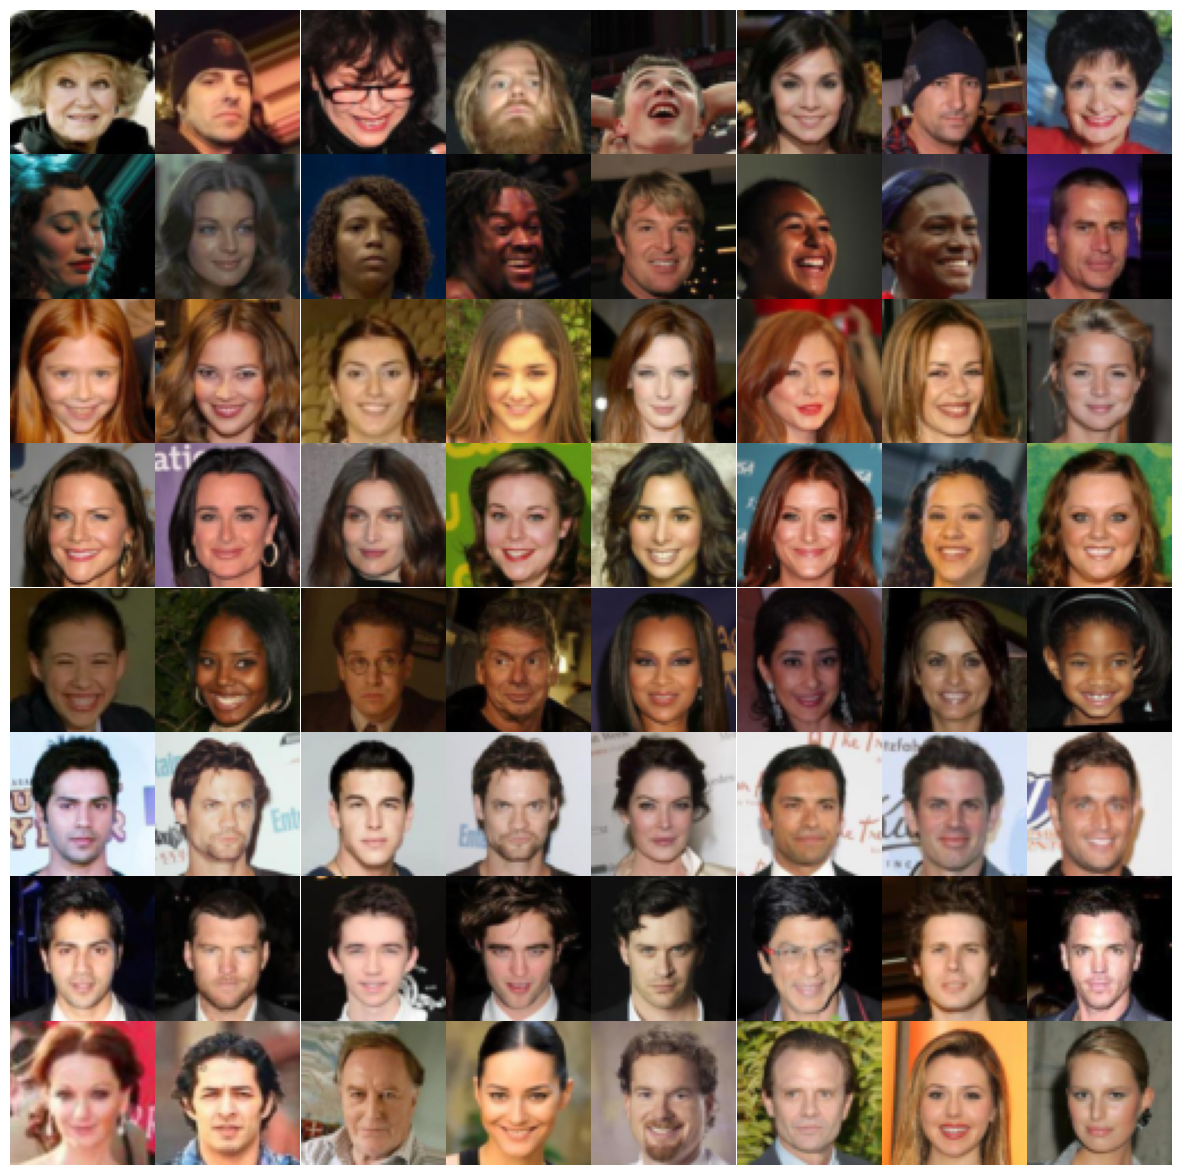

In [13]:
k = 8

f, axarr = plt.subplots(8, k, figsize=(15, 15))
for i, axarr_ in enumerate(axarr):
    D, I = index.search(xb[i].reshape(1, d), k)
    for j, axarr__ in enumerate(axarr_):
        axarr__.imshow((np.moveaxis(real_imgs[I[0][j]], 0, 2) + 1)/2)
        axarr__.axis('off')
f.subplots_adjust(wspace=0, hspace=0)